# Low Rank Tensor Fusion Model - CMU-MOSI Dataset

In this notebook, we implement the Low Rank Tensor Fusion Model, and test it on CMU-MOSI dataset.

## Importing Libraries

In [1]:
import os
import sys
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

## Importing Helper Functions

In [2]:
from helpers.data.get_data import get_dataloader
from helpers.unimodals.common_models import GRUWithLinear, MLP
from helpers.fusions.common_fusions import Concat, LowRankTensorFusion
from helpers.training.all_in_one import all_in_one_train
from helpers.training.supervised_learning import train, test
from helpers.utils.common_utils import get_default_device, save_results

## Loading the Dataset

In [3]:
traindata, validdata, testdata = get_dataloader(
    '/scratch/rrm9598/data/mosi_raw.pkl', robust_test=False)

In [4]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [5]:
encoders = [
    GRUWithLinear(35, 64, 32, dropout=True, has_padding=True).to(device),
    GRUWithLinear(74, 128, 32, dropout=True, has_padding=True).to(device),
    GRUWithLinear(300, 512, 128, dropout=True, has_padding=True).to(device)
]

head = MLP(128, 512, 1).to(device)

fusion = LowRankTensorFusion([32, 32, 128], 128, 32).to(device)

/scratch/rrm9598/Multimodal-Sentiment-Analysis/notebooks/helpers/fusions/common_fusions.py:309: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(factor)
/scratch/rrm9598/Multimodal-Sentiment-Analysis/notebooks/helpers/fusions/common_fusions.py:316: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.fusion_weights)


## Training

In [6]:
FILE_NAME = 'mosi_lrtfus_r0'

In [7]:
train_losses, valid_losses = train(
    encoders, fusion, head, traindata, validdata, 100, 
    task="regression", optimtype=torch.optim.AdamW,
    early_stop=False, is_packed=True, lr=1e-3, 
    save=f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt', 
    weight_decay=0.01, objective=torch.nn.L1Loss()
)

Epoch [1/100]
Train Loss: 1.3249
Valid Loss: 1.3745
Saving Best

Epoch [2/100]
Train Loss: 1.2928
Valid Loss: 1.4193

Epoch [3/100]
Train Loss: 1.2447
Valid Loss: 1.3400
Saving Best

Epoch [4/100]
Train Loss: 1.2389
Valid Loss: 1.3069
Saving Best

Epoch [5/100]
Train Loss: 1.1970
Valid Loss: 1.3255

Epoch [6/100]
Train Loss: 1.1537
Valid Loss: 1.3712

Epoch [7/100]
Train Loss: 1.1067
Valid Loss: 1.3059
Saving Best

Epoch [8/100]
Train Loss: 1.0804
Valid Loss: 1.3586

Epoch [9/100]
Train Loss: 1.0649
Valid Loss: 1.3026
Saving Best

Epoch [10/100]
Train Loss: 1.0302
Valid Loss: 1.2742
Saving Best

Epoch [11/100]
Train Loss: 0.9645
Valid Loss: 1.2112
Saving Best

Epoch [12/100]
Train Loss: 0.9417
Valid Loss: 1.2244

Epoch [13/100]
Train Loss: 0.8969
Valid Loss: 1.2516

Epoch [14/100]
Train Loss: 0.8886
Valid Loss: 1.2623

Epoch [15/100]
Train Loss: 0.8489
Valid Loss: 1.1859
Saving Best

Epoch [16/100]
Train Loss: 0.8013
Valid Loss: 1.2298

Epoch [17/100]
Train Loss: 0.7961
Valid Loss: 1.1

Text(0.5, 1.0, 'Loss vs. No. of epochs')

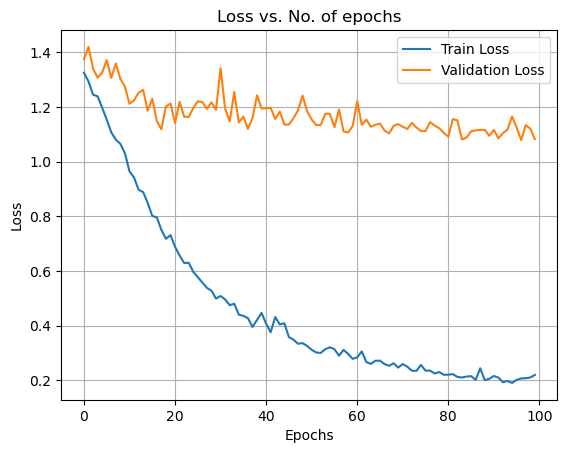

In [8]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [9]:
save_results(train_losses, valid_losses, f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/results/{FILE_NAME}.pkl')

## Testing

In [10]:
model = torch.load(f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt').to(device)

test(model, test_dataloaders_all=testdata, dataset='mosi',
     is_packed=True, criterion=torch.nn.L1Loss(), task='posneg-classification', no_robust=True)

Recall: 68.5976% | Total Accuracy: 68.0758%
Inference Time: 433ms
Inference Params: 1486465
